In [576]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession

import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [577]:
spark = SparkSession.builder.appName('DataTransformations').getOrCreate()
spark

* New_York_cars.csv veri seti; arabalar.com web sitesinden elde edilen araç fiyatlarını içermektedir

* New&used: Araç tipini (yeni veya kullanılmış) ifade eder.
* name: Araç adını temsil eder.
* money: Araç fiyatını ifade eder.
* Exterior color: Araçın dış rengini ifade eder.
* Interior color: Araçın iç rengini ifade eder.
* Drivetrain: Araç tahrik sistemini (örneğin, önden çekişli - Fwd) ifade eder.
* MPG: Araçın mil başına galon cinsinden yakıt tüketimini ifade eder.
* Fuel type: Araç yakıt tipini ifade eder.
* Transmission: Araç şanzıman tipini ifade eder.
* Engine: Araç motorunu ifade eder.
* Mileage: Araç kilometre bilgisini ifade eder.
* Convenience: Araçta bulunan konfor özelliklerini ifade eder.
* Entertainment: Araçta bulunan eğlence özelliklerini ifade eder.
* Exterior: Araç dış donanımını ifade eder.
* Safety: Araç güvenlik özelliklerini ifade eder.
* Seating: Araç koltuk düzenini ifade eder.
* Accidents or damage: Araçta meydana gelen kaza veya hasarı ifade eder.
* Clean title: Araç için temiz belge durumunu ifade eder.
* 1-owner vehicle: Araçın tek sahip olduğunu ifade eder.
* Personal use only: Araçın sadece kişisel kullanım için olduğunu ifade eder.
* brand: Araç markasını ifade eder.
* Year: Araç modelinin üretim yılını ifade eder.
* Model: Araç modelini ifade eder.
* currency: Para birimini ifade eder.

In [578]:
path = 'New_York_cars.csv'
df= spark.read.csv(path,header=True,inferSchema=True)
df.show(3)

+--------+--------------------+-----+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+--------------------+--------+
|new&used|                name|money|      Exterior color|Interior color|Drivetrain|   MPG|Fuel type|      Transmission|              Engine|Mileage|         Convenience|       Entertainment|            Exterior|              Safety|             Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|               Model|currency|
+--------+--------------------+-----+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--

In [579]:
df.count(), len(df.columns)

(175490, 24)

In [580]:
df.printSchema()

root
 |-- new&used: string (nullable = true)
 |-- name: string (nullable = true)
 |-- money: integer (nullable = true)
 |-- Exterior color: string (nullable = true)
 |-- Interior color: string (nullable = true)
 |-- Drivetrain: string (nullable = true)
 |-- MPG: string (nullable = true)
 |-- Fuel type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Engine: string (nullable = true)
 |-- Mileage: integer (nullable = true)
 |-- Convenience: string (nullable = true)
 |-- Entertainment: string (nullable = true)
 |-- Exterior: string (nullable = true)
 |-- Safety: string (nullable = true)
 |-- Seating: string (nullable = true)
 |-- Accidents or damage: string (nullable = true)
 |-- Clean title: string (nullable = true)
 |-- 1-owner vehicle: string (nullable = true)
 |-- Personal use only: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Model: string (nullable = true)
 |-- currency: string (nullable = true)



In [581]:
# eksik değerler kontrolü

from pyspark.sql import functions as F

# df içindeki eksik değerleri kontrol et
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show(5)

# eksik değer yüzdeleri
# Toplam satır sayısını al
total_rows = df.count()
# Her sütundaki eksik değerlerin yüzdesini hesapla ve göster
missing_percentage_df = df.select([(F.format_number(((F.sum(F.when(F.col(c).isNull(), 1)) / total_rows) * 100), 2)).alias(c) for c in df.columns])
missing_percentage_df.show(5)

+--------+----+-----+--------------+--------------+----------+-----+---------+------------+------+-------+-----------+-------------+--------+------+-------+-------------------+-----------+---------------+-----------------+-----+----+-----+--------+
|new&used|name|money|Exterior color|Interior color|Drivetrain|  MPG|Fuel type|Transmission|Engine|Mileage|Convenience|Entertainment|Exterior|Safety|Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|Model|currency|
+--------+----+-----+--------------+--------------+----------+-----+---------+------------+------+-------+-----------+-------------+--------+------+-------+-------------------+-----------+---------------+-----------------+-----+----+-----+--------+
|       0|   0|    0|          1892|         14896|       556|32084|     1343|         764|   332|     47|      29933|         8907|   16908|  1942|  57654|              52574|     157340|          52799|            52575|    0|   0|    0|       0|
+---

In [582]:
from pyspark.sql.functions import mean
mileage_mean = df.select(mean("Mileage")).collect()[0][0]
df = df.na.fill({"Mileage": mileage_mean})

df.show(3)

+--------+--------------------+-----+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+--------------------+--------+
|new&used|                name|money|      Exterior color|Interior color|Drivetrain|   MPG|Fuel type|      Transmission|              Engine|Mileage|         Convenience|       Entertainment|            Exterior|              Safety|             Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|               Model|currency|
+--------+--------------------+-----+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--

In [583]:
from pyspark.sql.functions import col

kolonlar = "Exterior color","Interior color","Drivetrain","Fuel type","Transmission","Engine","Entertainment","Exterior","Safety"
# Her bir sütunun modunu bulma
mod_values = {}
for column in kolonlar:
    mod = df.groupBy(column).count().orderBy(col("count").desc()).first()[0]
    mod_values[column] = mod

# Eksik değerleri mod değerleriyle doldurma
for column, mod in mod_values.items():
    df = df.na.fill({column: mod})

df.show(3)

+--------+--------------------+-----+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+--------------------+--------+
|new&used|                name|money|      Exterior color|Interior color|Drivetrain|   MPG|Fuel type|      Transmission|              Engine|Mileage|         Convenience|       Entertainment|            Exterior|              Safety|             Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|               Model|currency|
+--------+--------------------+-----+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--

In [584]:
kolonlar = ["MPG","Convenience","Seating","Accidents or damage","Clean title","1-owner vehicle","Personal use only"]
for col in kolonlar:
    df = df.fillna({col:"No Data"})
df.show(3)

+--------+--------------------+-----+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+--------------------+--------+
|new&used|                name|money|      Exterior color|Interior color|Drivetrain|   MPG|Fuel type|      Transmission|              Engine|Mileage|         Convenience|       Entertainment|            Exterior|              Safety|             Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|               Model|currency|
+--------+--------------------+-----+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--

In [585]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show(5)

+--------+----+-----+--------------+--------------+----------+---+---------+------------+------+-------+-----------+-------------+--------+------+-------+-------------------+-----------+---------------+-----------------+-----+----+-----+--------+
|new&used|name|money|Exterior color|Interior color|Drivetrain|MPG|Fuel type|Transmission|Engine|Mileage|Convenience|Entertainment|Exterior|Safety|Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|Model|currency|
+--------+----+-----+--------------+--------------+----------+---+---------+------------+------+-------+-----------+-------------+--------+------+-------+-------------------+-----------+---------------+-----------------+-----+----+-----+--------+
|       0|   0|    0|             0|             0|         0|  0|        0|           0|     0|      0|          0|            0|       0|     0|      0|                  0|          0|              0|                0|    0|   0|    0|       0|
+--------+--

In [586]:
from pyspark.sql.types import StringType
# Sayısal değişkenlerin listesi
numerical_features_1 = [field.name for field in df.schema.fields if field.dataType != StringType()]

year_feature = [feature for feature in numerical_features_1 if 'Yr' in feature or 'Year' in feature]

numerical_features_2 = [i for i in numerical_features_1 if i not in year_feature]

# Kategorik değişkenlerin sayısını kontrol etme
discrete_features = [feature for feature in numerical_features_2 if df.select(feature).distinct().count() < 25]

# Sürekli sayısal değişkenleri bulma
continuous_feature = [feature for feature in numerical_features_2 if feature not in discrete_features]

# Sürekli sayısal değişkenlerin isimlerini gösterme
for i in continuous_feature:
    print(i)


money
Mileage


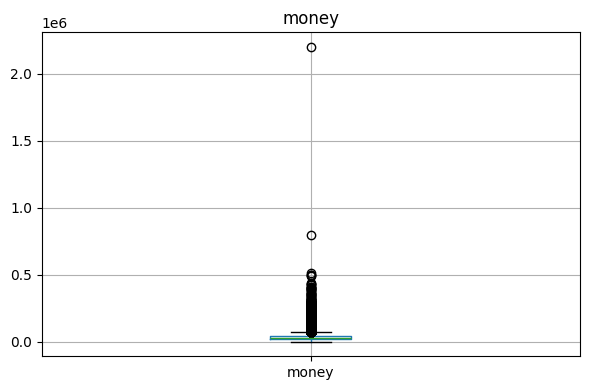

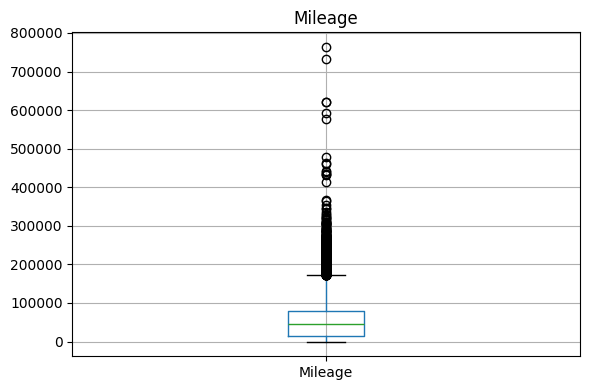

In [587]:
import matplotlib.pyplot as plt
for col in continuous_feature:
    quantiles = df.approxQuantile(col, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Sadece aykırı değerlere sahip sütunları çiz
    outlier_df = df.filter((df[col] < lower_limit) | (df[col] > upper_limit))
    if outlier_df.count() > 0:
        # Boxplot grafiği çiz
        plt.figure(figsize=(6, 4))
        df.select(col).toPandas().boxplot()
        plt.title(col)
        plt.tight_layout()
        plt.show()
    else:
        print(f"{col} sütununda aykırı değer bulunmamaktadır.")

In [588]:
from pyspark.sql.functions import when, col

def handle_outliers_with_min_max_limits(df, columns):
    for col_name in columns:
        quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
        Q1 = quantiles[0]
        Q3 = quantiles[1]
        IQR = Q3 - Q1

        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        df = df.withColumn(col_name, 
                           when(col(col_name) < lower_limit, lower_limit)
                           .when(col(col_name) > upper_limit, upper_limit)
                           .otherwise(col(col_name)))
    return df

# Aykırı değerleri düzeltmek istediğiniz sütunları seçin
selected_columns = continuous_feature

# Aykırı değerleri düzelt
df = handle_outliers_with_min_max_limits(df, selected_columns)
df.show(3)


+--------+--------------------+-------+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+--------------------+--------+
|new&used|                name|  money|      Exterior color|Interior color|Drivetrain|   MPG|Fuel type|      Transmission|              Engine|Mileage|         Convenience|       Entertainment|            Exterior|              Safety|             Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|               Model|currency|
+--------+--------------------+-------+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------

In [589]:
import matplotlib.pyplot as plt
for col in continuous_feature:
    quantiles = df.approxQuantile(col, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Sadece aykırı değerlere sahip sütunları çiz
    outlier_df = df.filter((df[col] < lower_limit) | (df[col] > upper_limit))
    if outlier_df.count() > 0:
        # Boxplot grafiği çiz
        plt.figure(figsize=(6, 4))
        df.select(col).toPandas().boxplot()
        plt.title(col)
        plt.tight_layout()
        plt.show()
    else:
        print(f"{col} sütununda aykırı değer bulunmamaktadır.")

money sütununda aykırı değer bulunmamaktadır.
Mileage sütununda aykırı değer bulunmamaktadır.


In [590]:
# veri tiplerini kontrol et

schema = df.schema
# Sütunları veri tipine göre gruplandır
grouped_columns = {}
for field in schema.fields:
    data_type = str(field.dataType)
    column_name = field.name
    grouped_columns.setdefault(data_type, []).append(column_name)

# Gruplandırılmış sütunları yazdır
for data_type, columns in grouped_columns.items():
    column_list = ", ".join(columns)
    print(f"{data_type}:\n{column_list}\n")

StringType():
new&used, name, Exterior color, Interior color, Drivetrain, MPG, Fuel type, Transmission, Engine, Convenience, Entertainment, Exterior, Safety, Seating, Accidents or damage, Clean title, 1-owner vehicle, Personal use only, brand, Model, currency

DoubleType():
money, Mileage

IntegerType():
Year



In [591]:
# sutunların benzersiz değerlerinin sayısı:
for col in df.columns:
    unique_values_count = df.select(col).distinct().count()
    print(f"{col}: {unique_values_count}")

new&used: 24
name: 15686
money: 33558
Exterior color: 3475
Interior color: 1865
Drivetrain: 4
MPG: 538
Fuel type: 17
Transmission: 631
Engine: 1316
Mileage: 86715
Convenience: 225
Entertainment: 61
Exterior: 15
Safety: 193
Seating: 8
Accidents or damage: 3
Clean title: 3
1-owner vehicle: 3
Personal use only: 3
brand: 30
Year: 12
Model: 5268
currency: 1


In [592]:
df.select("new&used").distinct().collect()

# new&used sutunun da 24 benzersiz değer var,bu değerleri New ve Used olacak şekilde değiştiriyorum

from pyspark.sql.functions import when, instr
df = df.withColumn("New_Used",
                   when(instr(df["new&used"], "New") > 0, "New")
                   .otherwise("Used"))

# Eski sütunu kaldırın
df = df.drop("new&used")

df.show(2)

+--------------------+-------+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+------------+--------+--------+
|                name|  money|      Exterior color|Interior color|Drivetrain|   MPG|Fuel type|      Transmission|              Engine|Mileage|         Convenience|       Entertainment|            Exterior|              Safety|             Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|       Model|currency|New_Used|
+--------------------+-------+--------------------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------

In [593]:
from pyspark.sql.functions import when, instr

# Metallic kelimesini içeren satırları filtreleyerek yeni bir sütun oluşturun
df = df.withColumn("Exterior_Color",
                   when(instr(df["Exterior color"], "Metallic") > 0, "Metalik")
                   .when((instr(df["Exterior color"], "unspecified") > 0) | (instr(df["Exterior color"], "tan") > 0), "Belirsiz")
                   .when((instr(df["Exterior color"], "pearlcoat") > 0) | (instr(df["Exterior color"], "matte") > 0), "Özel")
                   .otherwise("Standart"))

# Eski sütunu kaldırın
df = df.drop("Exterior color")

df.show(2)


+--------------------+-------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+------------+--------+--------+--------------+
|                name|  money|Interior color|Drivetrain|   MPG|Fuel type|      Transmission|              Engine|Mileage|         Convenience|       Entertainment|            Exterior|              Safety|             Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|       Model|currency|New_Used|Exterior_Color|
+--------------------+-------+--------------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+--

In [594]:
df.select("Interior color").distinct().collect()
# Interior color içerisinde ki değerleri Kahverengi,Mavi,Kırmızı,Altın,Siyah,Beyaz / Bej,Gri olacak şekilde değiştiriyorum

from pyspark.sql.functions import when, instr
df = df.withColumn("Interior_Color",
                   when(instr(df["Interior color"], "Brown") > 0, "Kahverengi")
                   .when(instr(df["Interior color"], "Blue") > 0, "Mavi")
                   .when(instr(df["Interior color"], "Red") > 0, "Kırmızı")
                   .when(instr(df["Interior color"], "Gold") > 0, "Altın")
                   .when((instr(df["Interior color"], "Gray") > 0) | (instr(df["Interior color"], "Pewter") > 0), "Gri")
                   .when((instr(df["Interior color"], "Black") > 0) | (instr(df["Interior color"], "Ebony") > 0), "Siyah")
                   .when((instr(df["Interior color"], "Beige") > 0) | (instr(df["Interior color"], "White") > 0), "Beyaz/Bej")
                   .otherwise("Diğer"))

# Eski sütunu kaldırın
df = df.drop("Interior color")

df.show(2)


+--------------------+-------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+------------+--------+--------+--------------+--------------+
|                name|  money|Drivetrain|   MPG|Fuel type|      Transmission|              Engine|Mileage|         Convenience|       Entertainment|            Exterior|              Safety|             Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|       Model|currency|New_Used|Exterior_Color|Interior_Color|
+--------------------+-------+----------+------+---------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+------------

In [595]:
df.select("Fuel type").distinct().collect()
# Fuel type değerlerini Dizel,Hibrit,Elektrik,Benzin,Diğer olacak şekilde değiştirdim

from pyspark.sql.functions import when, instr
df = df.withColumn("Full_type",
                   when(instr(df["Fuel type"], "Diesel") > 0, "Dizel")
                   .when(instr(df["Fuel type"], "Hybrid") > 0, "Hibrit")
                   .when(instr(df["Fuel type"], "Electric") > 0, "Elektrik")                  
                   .when((instr(df["Fuel type"], "Gasoline") > 0) | (instr(df["Fuel type"], "Regular Unleaded") > 0), "Benzin")
                   .otherwise("Diğer"))

# Eski sütunu kaldırın
df = df.drop("Fuel type")

df.show(2)

+--------------------+-------+----------+------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+------------+--------+--------+--------------+--------------+---------+
|                name|  money|Drivetrain|   MPG|      Transmission|              Engine|Mileage|         Convenience|       Entertainment|            Exterior|              Safety|             Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|       Model|currency|New_Used|Exterior_Color|Interior_Color|Full_type|
+--------------------+-------+----------+------+------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+------------+--------+

In [596]:
# herhangi bir sutundaki benzersiz değerler
df.select("Transmission").distinct().collect()
# Transmission değerlerini Manuel,CVT,Otomatik,Özel,Diğer diğer olarak değiştirdim

from pyspark.sql.functions import when, instr
df = df.withColumn("Transmissionn",
                   when(instr(df["Transmission"], "Manual") > 0, "Manuel")
                   .when(instr(df["Transmission"], "CVT") > 0, "CVT")
                   .when((instr(df["Transmission"], "Automatic") > 0) | (instr(df["Transmission"], "Auto") > 0), "Otomatik")
                   .when((instr(df["Transmission"], "Clutch") > 0) | (instr(df["Transmission"], "Sport Automatic") > 0), "Özel")
                   .otherwise("Diğer"))

# Eski sütunu kaldırın
df = df.drop("Transmission")

df.show(2)

+--------------------+-------+----------+------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+------------+--------+--------+--------------+--------------+---------+-------------+
|                name|  money|Drivetrain|   MPG|              Engine|Mileage|         Convenience|       Entertainment|            Exterior|              Safety|             Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|       Model|currency|New_Used|Exterior_Color|Interior_Color|Full_type|Transmissionn|
+--------------------+-------+----------+------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+------------+--------+--------+--------------+-----

In [597]:
df.select("Engine").distinct().collect()
# Engine verilerini İçten Yanmalı Benzinli,Hibrit,Dizel,Turboşarjlı,Diğer olarak değiştirdim
    
from pyspark.sql.functions import when, instr
df = df.withColumn("Enginee",
                   when(instr(df["Engine"], "Gas") > 0, "İçten Yanmalı Benzinli")
                   .when(instr(df["Engine"], "Hybrid") > 0, "Hibrit")
                   .when(instr(df["Engine"], "Diesel") > 0, "Dizel")
                   .when((instr(df["Engine"], "Turbocharged") > 0) | (instr(df["Engine"], "Intercooled Turbo") > 0), "Turboşarjlı")
                   .otherwise("Diğer"))

# Eski sütunu kaldırın
df = df.drop("Engine")

df.show(2)

+--------------------+-------+----------+------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+------------+--------+--------+--------------+--------------+---------+-------------+-------+
|                name|  money|Drivetrain|   MPG|Mileage|         Convenience|       Entertainment|            Exterior|              Safety|             Seating|Accidents or damage|Clean title|1-owner vehicle|Personal use only|brand|Year|       Model|currency|New_Used|Exterior_Color|Interior_Color|Full_type|Transmissionn|Enginee|
+--------------------+-------+----------+------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------+---------------+-----------------+-----+----+------------+--------+--------+--------------+--------------+---------+-------------+-------+
|202

In [598]:
# yukarıda çok fazla benzersiz değerleri olan ve encoder yapılamayacak sutunları, benzer özelliklerini dikkate alarak grupladım. Diğer sutunlara da bu yöntemler uygulanabilir. Ben işlem yaptığım grupları filtreleyip onlar üzerinden devam edeceğim. Amacım büyük resmi görebilmek

df1 = df[["New_Used","Exterior_Color","Interior_Color","Full_type","Transmissionn","Enginee","Drivetrain","Mileage","money"]]
df1.show(2)

+--------+--------------+--------------+---------+-------------+-------+----------+-------+-------+
|New_Used|Exterior_Color|Interior_Color|Full_type|Transmissionn|Enginee|Drivetrain|Mileage|  money|
+--------+--------------+--------------+---------+-------------+-------+----------+-------+-------+
|     New|       Metalik|         Siyah|   Benzin|     Otomatik|  Diğer|       Fwd|    5.0|33095.0|
|     New|      Standart|         Siyah|   Benzin|     Otomatik|  Diğer|       Awd|    0.0|61745.0|
+--------+--------------+--------------+---------+-------------+-------+----------+-------+-------+
only showing top 2 rows



In [599]:
# Belirtilen sütunlardaki benzersiz değerlerin alınması
unique_values = {}

for column in df1.columns:
    unique_values[column] = df1.select(column).distinct().collect()

# Benzersiz değerlerin yazdırılması
for column, values in unique_values.items():
    print(f"{column} Benzersiz Değerler:")
    for row in values:
        print(row[column])
    print("\n")

New_Used Benzersiz Değerler:
Used
New


Exterior_Color Benzersiz Değerler:
Metalik
Belirsiz
Standart
Özel


Interior_Color Benzersiz Değerler:
Kırmızı
Beyaz/Bej
Gri
Kahverengi
Mavi
Diğer
Altın
Siyah


Full_type Benzersiz Değerler:
Diğer
Benzin
Hibrit
Elektrik
Dizel


Transmissionn Benzersiz Değerler:
Diğer
Özel
Manuel
Otomatik


Enginee Benzersiz Değerler:
Diğer
Turboşarjlı
Hibrit
İçten Yanmalı Benzinli
Dizel


Drivetrain Benzersiz Değerler:
Rwd
Awd
Fwd
4Wd


Mileage Benzersiz Değerler:
7313.0
41060.0
14269.0
27240.0
84170.0
16916.0
93703.0
52633.0
48482.0
85005.0
62742.0
101418.0
118458.0
4800.0
11430.0
35340.0
20948.0
37304.0
35156.0
39763.0
39252.0
42071.0
30111.0
36797.0
36818.0
79463.0
110671.0
79345.0
142938.0
16822.0
10129.0
12493.0
29410.0
42470.0
15846.0
27552.0
17072.0
29367.0
11766.0
24594.0
36504.0
67691.0
69457.0
64409.0
25813.0
73054.0
54050.0
29559.0
63867.0
48629.0
62463.0
60730.0
134191.0
78888.0
110056.0
97391.0
99505.0
143261.0
66344.0
76173.0
69989.0
25175.0
44449.0

### Encoder

In [600]:
# veri tiplerini kontrol et

# DataFrame şemasını al
schema = df1.schema
# Sütunları veri tipine göre gruplandır
grouped_columns = {}
for field in schema.fields:
    data_type = str(field.dataType)
    column_name = field.name
    grouped_columns.setdefault(data_type, []).append(column_name)
# Gruplandırılmış sütunları yazdır
for data_type, columns in grouped_columns.items():
    column_list = ", ".join(columns)
    print(f"{data_type}:\n{column_list}\n")

StringType():
New_Used, Exterior_Color, Interior_Color, Full_type, Transmissionn, Enginee, Drivetrain

DoubleType():
Mileage, money



In [601]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

# StringIndexer kullanarak kategorik sütunları indeksleyin
cols = ['New_Used','Exterior_Color','Interior_Color','Full_type','Transmissionn','Enginee','Drivetrain']
stringIndexer = StringIndexer(inputCols=cols, outputCols=[col + '_Index' for col in cols])
indexed_df1 = stringIndexer.fit(df1).transform(df1)
# OneHotEncoder ile indekslenen sütunları dönüştürün
encoder = OneHotEncoder(inputCols=[col + '_Index' for col in cols], 
                        outputCols=[col + '_Vec' for col in cols])
encoded_df1 = encoder.fit(indexed_df1).transform(indexed_df1)
# Orjinal kategorik sütunları veri çerçevesinden kaldırın
encoded_cols = [col + '_Index' for col in cols] + cols
df1 = encoded_df1.drop(*encoded_cols)

df1.show(5)

+-------+-------+------------+------------------+------------------+-------------+-----------------+-------------+--------------+
|Mileage|  money|New_Used_Vec|Exterior_Color_Vec|Interior_Color_Vec|Full_type_Vec|Transmissionn_Vec|  Enginee_Vec|Drivetrain_Vec|
+-------+-------+------------+------------------+------------------+-------------+-----------------+-------------+--------------+
|    5.0|33095.0|   (1,[],[])|     (3,[1],[1.0])|     (7,[0],[1.0])|(4,[0],[1.0])|    (3,[0],[1.0])|(4,[0],[1.0])| (3,[1],[1.0])|
|    0.0|61745.0|   (1,[],[])|     (3,[0],[1.0])|     (7,[0],[1.0])|(4,[0],[1.0])|    (3,[0],[1.0])|(4,[0],[1.0])| (3,[0],[1.0])|
|    5.0|38095.0|   (1,[],[])|     (3,[0],[1.0])|     (7,[0],[1.0])|(4,[0],[1.0])|    (3,[2],[1.0])|(4,[0],[1.0])| (3,[1],[1.0])|
|   11.0|47995.0|   (1,[],[])|     (3,[0],[1.0])|     (7,[0],[1.0])|(4,[0],[1.0])|    (3,[0],[1.0])|(4,[0],[1.0])| (3,[1],[1.0])|
|    2.0|47995.0|   (1,[],[])|     (3,[0],[1.0])|     (7,[4],[1.0])|(4,[0],[1.0])|    (3,[

In [602]:
# features kolonunu oluşturma

from pyspark.ml.feature import VectorAssembler
x_columns = ["Mileage", "New_Used_Vec", "Exterior_Color_Vec", "Interior_Color_Vec", "Full_type_Vec", "Transmissionn_Vec", "Enginee_Vec", "Drivetrain_Vec"]
assembler = VectorAssembler(inputCols=x_columns, outputCol='features')
output = assembler.transform(df1)
df1 = output.select('features', output['money'].alias('label'))
df1.show(3)

+--------------------+-------+
|            features|  label|
+--------------------+-------+
|(26,[0,3,5,12,16,...|33095.0|
|(26,[2,5,12,16,19...|61745.0|
|(26,[0,2,5,12,18,...|38095.0|
+--------------------+-------+
only showing top 3 rows



In [619]:
from pyspark.ml.feature import StandardScaler

# StandardScaler'ı oluşturun ve 'features' sütununa uygulayın
scaler = StandardScaler(inputCol='features', outputCol='std_features')
df1_scaled = scaler.fit(df1).transform(df1)
df1_scaled = df1_scaled.drop("features")
df1_scaled.show(3)


+-------+--------------------+
|  label|        std_features|
+-------+--------------------+
|33095.0|(26,[0,3,5,12,16,...|
|61745.0|(26,[2,5,12,16,19...|
|38095.0|(26,[0,2,5,12,18,...|
+-------+--------------------+
only showing top 3 rows



In [621]:
df2 = df1_scaled.select(df1_scaled['std_features'].alias('features'), df1_scaled["label"])
df2.show(5)

+--------------------+-------+
|            features|  label|
+--------------------+-------+
|(26,[0,3,5,12,16,...|33095.0|
|(26,[2,5,12,16,19...|61745.0|
|(26,[0,2,5,12,18,...|38095.0|
|(26,[0,2,5,12,16,...|47995.0|
|(26,[0,2,9,12,16,...|47995.0|
+--------------------+-------+
only showing top 5 rows



In [622]:
train, test = df2.randomSplit([0.8, 0.2], seed=42)

In [623]:
# grid search, best parameter, random forest regression

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol='label')

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 20])
             .addGrid(rf.numTrees, [10, 20, 50])
             .build())

# Değerlendirme metriği oluşturma
evaluator = RegressionEvaluator(metricName="rmse")

# Çapraz doğrulama oluşturma
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

# Modeli eğitme
cvModel = cv.fit(train)

In [626]:
# çapraz doğrulama sürecinde en iyi performansı gösteren modeli içerir.
best_rf_model = cvModel.bestModel
best_rf_model

RandomForestRegressionModel: uid=RandomForestRegressor_0a41fb100c62, numTrees=50, numFeatures=26

In [628]:
# best parameter ile en iyi modeli oluştur

from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(numTrees=50,maxDepth=26)
rf.setSeed(42)
model = rf.fit(train)

In [629]:
feature_Importances = list(model.featureImportances)
feats = output.columns[:-2]
d = dict(zip(feats, feature_Importances))
sorted_dict = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

# Sıralı sözlüğü yazdırma
for feature, importance in sorted_dict.items():
    print(f"{feature}: {importance}")

Mileage: 0.5183379367236409
money: 0.14140592838807783
Enginee_Vec: 0.00974057974618502
Transmissionn_Vec: 0.00593711408717514
Full_type_Vec: 0.005247107584324888
Exterior_Color_Vec: 0.0029021774795610386
New_Used_Vec: 0.0026555959236073527
Interior_Color_Vec: 0.00038532975687022747


In [630]:
# Train seti üzerinde tahminler yapın
train_predictions = model.transform(train)

In [631]:
from pyspark.ml.evaluation import RegressionEvaluator

print("Train seti")
evaluator = RegressionEvaluator(metricName="rmse")
print("RMSE = %g" % evaluator.evaluate(train_predictions))

evaluator = RegressionEvaluator(metricName="r2")
print("R Squared (R2) = %g" % evaluator.evaluate(train_predictions))

evaluator = RegressionEvaluator(metricName="mse")
print("MSE = %g" % evaluator.evaluate(train_predictions))

Train seti
RMSE = 9274.22
R Squared (R2) = 0.676995
MSE = 8.60112e+07


In [632]:
predictions = model.transform(test)
predictions.show(3)

+--------------------+-------+------------------+
|            features|  label|        prediction|
+--------------------+-------+------------------+
|(26,[0,1,2,5,12,1...|33999.0| 49159.51134689233|
|(26,[0,1,2,5,12,1...|27991.0|41222.302832514084|
|(26,[0,1,2,5,12,1...|27995.0| 33396.42035265503|
+--------------------+-------+------------------+
only showing top 3 rows



In [633]:
from pyspark.ml.evaluation import RegressionEvaluator

print("Test seti")
evaluator = RegressionEvaluator(metricName="rmse")
print("RMSE = %g" % evaluator.evaluate(predictions))

evaluator = RegressionEvaluator(metricName="r2")
print("R Squared (R2) = %g" % evaluator.evaluate(predictions))

evaluator = RegressionEvaluator(metricName="mse")
print("MSE = %g" % evaluator.evaluate(predictions))

print()

print("Train seti")
evaluator = RegressionEvaluator(metricName="rmse")
print("RMSE = %g" % evaluator.evaluate(train_predictions))

evaluator = RegressionEvaluator(metricName="r2")
print("R Squared (R2) = %g" % evaluator.evaluate(train_predictions))

evaluator = RegressionEvaluator(metricName="mse")
print("MSE = %g" % evaluator.evaluate(train_predictions))

Test seti
RMSE = 9548.66
R Squared (R2) = 0.654644
MSE = 9.11768e+07

Train seti
RMSE = 9274.22
R Squared (R2) = 0.676995
MSE = 8.60112e+07
